In [1]:
import pandas as pd
import numpy as np
import pycmap
from datetime import datetime, timedelta
import pytz
import matplotlib.pyplot as plt
import os
import glob

## Calling in Hyperpro surface PAR (not using this for plots)

In [2]:
df = pd.read_csv('Gradients 4 - TN397 - Underway Hyperpro - Surface PAR.csv')
df

,time,lat,lon,surface_par
0,2021-11-19T16:32:00.000Z,31.165718,-119.755471,261.039130
1,2021-11-19T16:33:00.000Z,31.163667,-119.758933,302.072143
2,2021-11-19T16:34:00.000Z,31.161601,-119.762415,334.165926
3,2021-11-19T16:35:00.000Z,31.159584,-119.765842,300.941852
4,2021-11-19T16:36:00.000Z,31.157534,-119.769285,300.182593
...,...,...,...,...
34835,2021-12-13T21:07:00.000Z,14.906083,-152.971349,1298.340625
34836,2021-12-13T21:08:00.000Z,14.908998,-152.973812,1292.753636
34837,2021-12-13T21:09:00.000Z,14.911905,-152.976272,1292.897273
34838,2021-12-13T21:10:00.000Z,14.914838,-152.978767,1294.515938


## Reading in g4 licor txt files

In [3]:
# Folder Path
path = '/Users/ceg/Desktop/kristine/SACNAS-2023-project/G4_LICOR'
file_list = []  
# Change the directory
os.chdir(path)
  
# Read text File
 
def read_text_file(file_path):
    with open(file_path, 'r') as f:
        return(f.read())


# iterate through all file
for file in os.listdir():
    # Check whether file is in text format or not
    if file.endswith(".txt"):
        file_path = f"{path}/{file}"
  
        # call read text file function
        file_list.append(pd.read_table(file_path, header = None, on_bad_lines = 'skip'))

## Editing and refining g4 licor txt files into a dataframe

In [4]:
licor_par = pd.concat(file_list, ignore_index = True)
licor_par.columns = ['del', 'datetime', 'mean_PAR', 'del1', 'del2', 'del3']
licor_par.drop(['del', 'del1', 'del2', 'del3'], axis=1, inplace = True)
licor_par['datetime'] = pd.DatetimeIndex(licor_par.datetime.values).tz_localize('UTC')
licor_par.sort_values(by='datetime', inplace = True)
licor_par.reset_index(inplace = True)
licor_par.drop(['index'], axis=1, inplace = True)

# thought i fixed index issue but it got messed up again

In [5]:
licor_hourly = licor_par.groupby([pd.Grouper(key = 'datetime', freq = 'H')]).agg({'mean_PAR': 'mean'}).reset_index()
licor_hourly

,datetime,mean_PAR
0,2021-11-19 16:00:00+00:00,401.968333
1,2021-11-19 17:00:00+00:00,486.087167
2,2021-11-19 18:00:00+00:00,891.885167
3,2021-11-19 19:00:00+00:00,1092.274333
4,2021-11-19 20:00:00+00:00,1002.763667
...,...,...
577,2021-12-13 17:00:00+00:00,234.544417
578,2021-12-13 18:00:00+00:00,688.223000
579,2021-12-13 19:00:00+00:00,1092.185333
580,2021-12-13 20:00:00+00:00,1320.478000


In [32]:
# this df is the calibrated par after using correction factors
## find tn3917_130 
#cf_list = pd.read_csv('/Users/ceg/Desktop/kristine/SACNAS-2023-project/sfl_correction_factors.csv')
#cf_list.rename(columns = {'0':'PAR'}, inplace = True)
#cf_list

In [6]:
uncalib_par = pd.read_csv('/Users/ceg/Desktop/kristine/SACNAS-2023-project/tn397_130_uncalib_par.csv')
uncalib_par.drop(['Unnamed: 0'], axis = 1, inplace = True)
uncalib_par['sat_par'] = uncalib_par['PAR'].apply(lambda x: x*0.627)
uncalib_par['Date'] = pd.DatetimeIndex(uncalib_par.Date.values)
uncalib_par

,Date,cruise,PAR,sat_par
0,2021-11-19 03:00:00+00:00,TN397_130,0.027400,0.017180
1,2021-11-19 14:00:00+00:00,TN397_130,32.932143,20.648454
2,2021-11-19 15:00:00+00:00,TN397_130,257.557450,161.488521
3,2021-11-19 16:00:00+00:00,TN397_130,616.760250,386.708677
4,2021-11-19 17:00:00+00:00,TN397_130,919.520650,576.539448
...,...,...,...,...
559,2021-12-14 18:00:00+00:00,TN397_130,1503.636550,942.780117
560,2021-12-14 19:00:00+00:00,TN397_130,2062.811100,1293.382560
561,2021-12-14 20:00:00+00:00,TN397_130,2203.142400,1381.370285
562,2021-12-14 21:00:00+00:00,TN397_130,1691.695200,1060.692890


In [7]:
big_par = pd.merge(uncalib_par, licor_hourly, left_on = 'Date', right_on = 'datetime', how = 'inner')
big_par
## mean par is licor par

,Date,cruise,PAR,sat_par,datetime,mean_PAR
0,2021-11-19 16:00:00+00:00,TN397_130,616.76025,386.708677,2021-11-19 16:00:00+00:00,401.968333
1,2021-11-19 17:00:00+00:00,TN397_130,919.52065,576.539448,2021-11-19 17:00:00+00:00,486.087167
2,2021-11-19 18:00:00+00:00,TN397_130,1736.45065,1088.754558,2021-11-19 18:00:00+00:00,891.885167
3,2021-11-19 19:00:00+00:00,TN397_130,2051.71865,1286.427594,2021-11-19 19:00:00+00:00,1092.274333
4,2021-11-19 20:00:00+00:00,TN397_130,1942.10815,1217.701810,2021-11-19 20:00:00+00:00,1002.763667
...,...,...,...,...,...,...
548,2021-12-13 17:00:00+00:00,TN397_130,1087.53195,681.882533,2021-12-13 17:00:00+00:00,234.544417
549,2021-12-13 18:00:00+00:00,TN397_130,1930.60225,1210.487611,2021-12-13 18:00:00+00:00,688.223000
550,2021-12-13 19:00:00+00:00,TN397_130,2020.02810,1266.557619,2021-12-13 19:00:00+00:00,1092.185333
551,2021-12-13 20:00:00+00:00,TN397_130,2178.22065,1365.744348,2021-12-13 20:00:00+00:00,1320.478000


In [8]:
sat_par = uncalib_par.copy()
sat_par['PAR'] = sat_par['PAR'].apply(lambda x: x*0.627)
sat_par#.to_csv('sat_par.csv')

,Date,cruise,PAR,sat_par
0,2021-11-19 03:00:00+00:00,TN397_130,0.017180,0.017180
1,2021-11-19 14:00:00+00:00,TN397_130,20.648454,20.648454
2,2021-11-19 15:00:00+00:00,TN397_130,161.488521,161.488521
3,2021-11-19 16:00:00+00:00,TN397_130,386.708677,386.708677
4,2021-11-19 17:00:00+00:00,TN397_130,576.539448,576.539448
...,...,...,...,...
559,2021-12-14 18:00:00+00:00,TN397_130,942.780117,942.780117
560,2021-12-14 19:00:00+00:00,TN397_130,1293.382560,1293.382560
561,2021-12-14 20:00:00+00:00,TN397_130,1381.370285,1381.370285
562,2021-12-14 21:00:00+00:00,TN397_130,1060.692890,1060.692890


## Plots for all par data against time

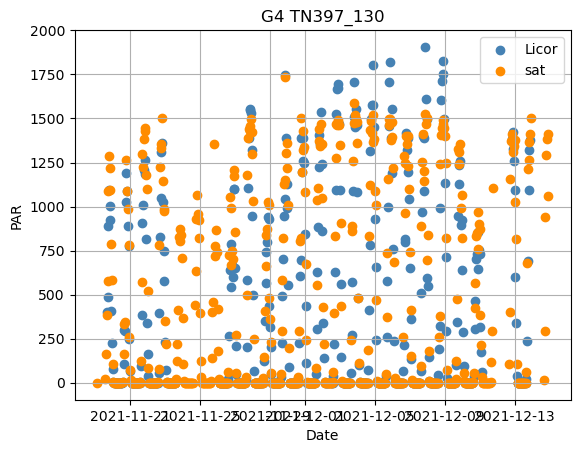

In [9]:
x1 = licor_hourly['datetime']
x2 = uncalib_par['Date']
y1 = licor_hourly['mean_PAR']
y2 = uncalib_par['PAR']
y3 = sat_par['PAR']


plt.scatter(x1, y1, color='steelblue', label='Licor')
#plt.scatter(x2, y2, color='black', label='uncalib')
plt.scatter(x2, y3, color='darkorange', label='sat')


plt.xlabel("Date")
plt.ylabel("PAR")
plt.title("G4 TN397_130")
plt.grid()
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


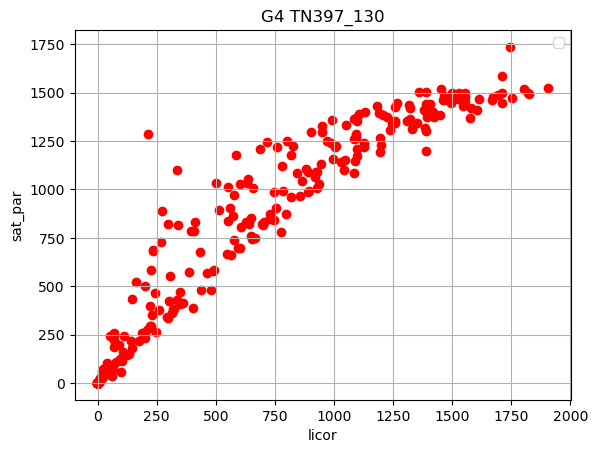

In [10]:
x = big_par['mean_PAR']
y = big_par['sat_par']

plt.scatter(x, y, color='red')

plt.xlabel("licor")
plt.ylabel("sat_par")
plt.title("G4 TN397_130")
plt.grid()
plt.legend()